In [5]:
import os
import sys
import shutil
import json
import logging
import pathlib

In [6]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)


def create_folder(folder_path: str):
    fp = pathlib.Path(folder_path)
    if fp.exists():
        logging.info(f"Directory {folder_path} already exists!")
    else:
        logging.info(f"Creating the directory: {folder_path}...")
        fp.mkdir(parents=True, exist_ok=True)
        logging.info(f"Directory {folder_path} created!")

This setup follows the tutorial provide by the TensorFlow: https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#preparing-the-workspace

# Directories

- **annotations:** This folder will be used to store all *.csv files and the respective TensorFlow *.record files, which contain the list of annotations for our dataset images.

- **exported-models:** This folder will be used to store exported versions of our trained model(s).

- **images:** This folder contains a copy of all the images in our dataset, as well as the respective *.xml files produced for each one, once labelImg is used to annotate objects.

    - images/train: This folder contains a copy of all images, and the respective *.xml files, which will be used to train our model.

    - images/test: This folder contains a copy of all images, and the respective *.xml files, which will be used to test our model.

- **models:** This folder will contain a sub-folder for each of training job. Each subfolder will contain the training pipeline configuration file *.config, as well as all files generated during the training and evaluation of our model.

- **pre-trained-models:** This folder will contain the downloaded pre-trained models, which shall be used as a starting checkpoint for our training jobs.

- **README.md:** This is an optional file which provides some general information regarding the training conditions of our model. It is not used by TensorFlow in any way, but it generally helps when you have a few training folders and/or you are revisiting a trained model after some time.

In [7]:
TENSORFLOW_PATH = "TensorFlow"
OBJECT_DETECTION_API_PATH = os.path.join("TensorFlow", "models")
WORKSPACE_PATH = os.path.join(TENSORFLOW_PATH, "workspace")
TRAINING_PATH = os.path.join(WORKSPACE_PATH, "training")
ANNOTATIONS_PATH = os.path.join(TRAINING_PATH, "annotations")
IMAGES_PATH = os.path.join(TRAINING_PATH, "images")
IMAGES_TRAIN_PATH = os.path.join(IMAGES_PATH, "train")
IMAGES_TEST_PATH = os.path.join(IMAGES_PATH, "test")
MODELS_PATH = os.path.join(TRAINING_PATH, "models")
PRE_TRAINED_MODELS_PATH = os.path.join(TRAINING_PATH, "pre-trained-models")
SCRIPTS_PATH = os.path.join(TENSORFLOW_PATH, "scripts")

In [8]:
# Creating all the directories
create_folder(TENSORFLOW_PATH)
create_folder(WORKSPACE_PATH)
create_folder(ANNOTATIONS_PATH)
create_folder(IMAGES_PATH)
create_folder(IMAGES_TRAIN_PATH)
create_folder(IMAGES_TEST_PATH)
create_folder(MODELS_PATH)
create_folder(PRE_TRAINED_MODELS_PATH)
create_folder(SCRIPTS_PATH)

2023-03-23 23:33:13 INFO Creating the directory: TensorFlow...
2023-03-23 23:33:13 INFO Directory TensorFlow created!
2023-03-23 23:33:13 INFO Creating the directory: TensorFlow/workspace...
2023-03-23 23:33:13 INFO Directory TensorFlow/workspace created!
2023-03-23 23:33:13 INFO Creating the directory: TensorFlow/workspace/training/annotations...
2023-03-23 23:33:13 INFO Directory TensorFlow/workspace/training/annotations created!
2023-03-23 23:33:13 INFO Creating the directory: TensorFlow/workspace/training/images...
2023-03-23 23:33:13 INFO Directory TensorFlow/workspace/training/images created!
2023-03-23 23:33:13 INFO Creating the directory: TensorFlow/workspace/training/images/train...
2023-03-23 23:33:13 INFO Directory TensorFlow/workspace/training/images/train created!
2023-03-23 23:33:13 INFO Creating the directory: TensorFlow/workspace/training/images/test...
2023-03-23 23:33:13 INFO Directory TensorFlow/workspace/training/images/test created!
2023-03-23 23:33:13 INFO Creatin

# Object Detection API

You need to download and install the object detection api. Link with a full resource of how to install: https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/index.html

I'll skip all the processes of installation cuda/cudnn support, protobuf, ... Please see the link above is much more complete than I can write it here.

In [9]:
!cd {TENSORFLOW_PATH} && git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 82600, done.
remote: Counting objects: 100% (506/506), done.
remote: Compressing objects: 100% (219/219), done.
remote: Total 82600 (delta 324), reused 443 (delta 287), pack-reused 82094
Receiving objects: 100% (82600/82600), 596.54 MiB | 10.91 MiB/s, done.
Resolving deltas: 100% (58947/58947), done.


In [10]:
# Attetion here: you need protoc in your PATH (see the tutorial above)
!cd TensorFlow/models/research/ && protoc object_detection/protos/*.proto --python_out=.

In [11]:
!cd TensorFlow/models/research/ && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Processing /home/brenoav/GitHub/ComputerVision/ObjectDetection/Object-Detection-API-TF/TensorFlow/models/research
  Preparing metadata (setup.py) ... done


  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1655312 sha256=4785316f318c12ec90d9706e8a57710d46ce4300f8f053fba91116892504a8fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-mffb_a44/wheels/f8/7e/ab/f673c49869913e4b28fe7af8d7f8702498bb717ad776874d04
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [12]:
# Testing if everything occors okay
!cd TensorFlow/models/research/ && python object_detection/builders/model_builder_tf2_test.py

2023-03-23 23:34:22.462573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 23:34:23.094822: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-23 23:34:23.094868: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-23 23:34:23.094890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_faster_rcnn_models_from_config_faster_rcnn_without_matmul): 0.07s
I0323 23:34:27.895219 140030039799040 test_util.py:2457] time(__main__.ModelBuilderTF2Test.test_create_faster_rcnn_models_from_config_faster_rcnn_without_matmul): 0.07s
[       OK ] ModelBuilderTF2Test.test_create_faster_rcnn_models_from_config_faster_rcnn_without_matmul
[ RUN      ] ModelBuilderTF2Test.test_create_faster_rcnn_models_from_config_mask_rcnn_with_matmul
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_faster_rcnn_models_from_config_mask_rcnn_with_matmul): 0.08s
I0323 23:34:27.972570 140030039799040 test_util.py:2457] time(__main__.ModelBuilderTF2Test.test_create_faster_rcnn_models_from_config_mask_rcnn_with_matmul): 0.08s
[       OK ] ModelBuilderTF2Test.test_create_faster_rcnn_models_from_config_mask_rcnn_with_matmul
[ RUN      ] ModelBuilderTF2Test.test_create_faster_rcnn_models_from_config_mask_rcnn_without_matmul
INFO:tensorflow:

I0323 23:34:30.754508 140030039799040 ssd_efficientnet_bifpn_feature_extractor.py:150] EfficientDet EfficientNet backbone version: efficientnet-b2
I0323 23:34:30.754596 140030039799040 ssd_efficientnet_bifpn_feature_extractor.py:152] EfficientDet BiFPN num filters: 112
I0323 23:34:30.754638 140030039799040 ssd_efficientnet_bifpn_feature_extractor.py:153] EfficientDet BiFPN num iterations: 5
I0323 23:34:30.755810 140030039799040 efficientnet_model.py:143] round_filter input=32 output=32
I0323 23:34:30.767727 140030039799040 efficientnet_model.py:143] round_filter input=32 output=32
I0323 23:34:30.767800 140030039799040 efficientnet_model.py:143] round_filter input=16 output=16
I0323 23:34:30.859213 140030039799040 efficientnet_model.py:143] round_filter input=16 output=16
I0323 23:34:30.859301 140030039799040 efficientnet_model.py:143] round_filter input=24 output=24
I0323 23:34:31.030472 140030039799040 efficientnet_model.py:143] round_filter input=24 output=24
I0323 23:34:31.030561 14

I0323 23:34:34.060732 140030039799040 efficientnet_model.py:143] round_filter input=16 output=24
I0323 23:34:34.060863 140030039799040 efficientnet_model.py:143] round_filter input=24 output=32
I0323 23:34:34.292645 140030039799040 efficientnet_model.py:143] round_filter input=24 output=32
I0323 23:34:34.292733 140030039799040 efficientnet_model.py:143] round_filter input=40 output=56
I0323 23:34:34.526257 140030039799040 efficientnet_model.py:143] round_filter input=40 output=56
I0323 23:34:34.526345 140030039799040 efficientnet_model.py:143] round_filter input=80 output=112
I0323 23:34:34.867956 140030039799040 efficientnet_model.py:143] round_filter input=80 output=112
I0323 23:34:34.868045 140030039799040 efficientnet_model.py:143] round_filter input=112 output=160
I0323 23:34:35.220256 140030039799040 efficientnet_model.py:143] round_filter input=112 output=160
I0323 23:34:35.220344 140030039799040 efficientnet_model.py:143] round_filter input=192 output=272
I0323 23:34:35.846732 

I0323 23:34:40.541740 140030039799040 efficientnet_model.py:143] round_filter input=112 output=200
I0323 23:34:40.541828 140030039799040 efficientnet_model.py:143] round_filter input=192 output=344
I0323 23:34:41.238887 140030039799040 efficientnet_model.py:143] round_filter input=192 output=344
I0323 23:34:41.238983 140030039799040 efficientnet_model.py:143] round_filter input=320 output=576
I0323 23:34:41.432032 140030039799040 efficientnet_model.py:143] round_filter input=1280 output=2304
I0323 23:34:41.458800 140030039799040 efficientnet_model.py:453] Building model efficientnet with params ModelConfig(width_coefficient=1.8, depth_coefficient=2.6, resolution=528, dropout_rate=0.5, blocks=(BlockConfig(input_filters=32, output_filters=16, kernel_size=3, num_repeat=1, expand_ratio=1, strides=(1, 1), se_ratio=0.25, id_skip=True, fused_conv=False, conv_type='depthwise'), BlockConfig(input_filters=16, output_filters=24, kernel_size=3, num_repeat=2, expand_ratio=6, strides=(2, 2), se_rati

In the end if everythign occors okay you have something like: `OK (skipped=1)`

# Splitting images set into training and testing sets

Split your data into the folders (with the .xml files):

- TensorFlow/workspace/training/images/train
- TensorFlow/workspace/training/images/test

# Creating TF Records

In [13]:
!curl https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py -o {SCRIPTS_PATH}/generate_tfrecord.py 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6410  100  6410    0     0   6779      0 --:--:-- --:--:-- --:--:--  6775


## Create Label Map

In [14]:
# List of Dicts
CLASSES = [
    {
     "id": 1,
     "name": "hole",
        
    },
]

In [15]:
with open(os.path.join(ANNOTATIONS_PATH, "label_map.pbtxt"), "w", encoding="utf-8") as file:
    for c in CLASSES:
        file.write("item {\n")
        file.write(f"  id: {c['id']}\n")
        file.write(f"  name: \'{c['name']}\'\n")
        file.write("}\n\n")

## Train Record

In [16]:
# Create train data:
!python {SCRIPTS_PATH}/generate_tfrecord.py -x {IMAGES_TRAIN_PATH} -l {ANNOTATIONS_PATH}/label_map.pbtxt -o {ANNOTATIONS_PATH}/train.record

Successfully created the TFRecord file: TensorFlow/workspace/training/annotations/train.record


## Test Record

In [17]:
# Create test data:
!python {SCRIPTS_PATH}/generate_tfrecord.py -x {IMAGES_TEST_PATH} -l {ANNOTATIONS_PATH}/label_map.pbtxt -o {ANNOTATIONS_PATH}/test.record

Successfully created the TFRecord file: TensorFlow/workspace/training/annotations/test.record


# Configuring the Training Job

We can download pre-configurated training job from https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md. I'll use http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz this one for this application.

In [18]:
MODEL_NAME = "ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8"

os.path.join(PRE_TRAINED_MODELS_PATH, MODEL_NAME)

'TensorFlow/workspace/training/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'

In [19]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz -P {PRE_TRAINED_MODELS_PATH}

--2023-03-23 23:34:50--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.135.144, 2800:3f0:4004:809::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.135.144|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘TensorFlow/workspace/training/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  9.49MB/s    in 2.1s    

2023-03-23 23:34:53 (9.49 MB/s) - ‘TensorFlow/workspace/training/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]



In [20]:
# unzip tar.gz file with the model
!tar xaf {os.path.join(PRE_TRAINED_MODELS_PATH, MODEL_NAME) + ".tar.gz"} -C {PRE_TRAINED_MODELS_PATH}

In [21]:
# Creating a folder with our pipeline modification
MY_MODEL_NAME_PATH = os.path.join(MODELS_PATH, f"my_{MODEL_NAME}")
create_folder(MY_MODEL_NAME_PATH)

2023-03-23 23:34:54 INFO Creating the directory: TensorFlow/workspace/training/models/my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8...
2023-03-23 23:34:54 INFO Directory TensorFlow/workspace/training/models/my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8 created!


In [22]:
PIPELINE_MY_MODEL_NAME_PATH = os.path.join(MY_MODEL_NAME_PATH, "pipeline.config")

In [23]:
# copying the pipeline config

shutil.copyfile(os.path.join(PRE_TRAINED_MODELS_PATH, MODEL_NAME, "pipeline.config"), 
                PIPELINE_MY_MODEL_NAME_PATH)

'TensorFlow/workspace/training/models/my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'

- **ATTETION:** You need now to configurate the new pipeline config:
    - num_classes -> 1
    - batch_size -> 12
    - fine_tune_checkpoint -> TensorFlow/workspace/training/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0
    - fine_tune_checkpoint_type -> "detection"
    - train_input_reader:
        - label_map_path -> TensorFlow/workspace/training/annotations/label_map.pbtxt
        - input_path -> TensorFlow/workspace/training/annotations/train.record
    - eval_input_reader:
        - label_map_path -> TensorFlow/workspace/training/annotations/label_map.pbtxt
        - input_path -> TensorFlow/workspace/training/annotations/test.record

In [25]:
from object_detection.utils import config_util
print(config_util.get_configs_from_pipeline_file(PIPELINE_MY_MODEL_NAME_PATH))

{'model': ssd {
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 320
      width: 320
    }
  }
  feature_extractor {
    type: "ssd_mobilenet_v2_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 3.9999998989515007e-05
        }
      }
      initializer {
        random_normal_initializer {
          mean: 0.0
          stddev: 0.009999999776482582
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    use_depthwise: true
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
      additional_layer_depth: 128
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_thresho

# Training

## Copying the script of training to training folder

In [26]:
shutil.copyfile(os.path.join(OBJECT_DETECTION_API_PATH, "research", "object_detection", "model_main_tf2.py"), 
                "model_main_tf2.py")

'model_main_tf2.py'

In [29]:
command = f"python model_main_tf2.py --model_dir={MY_MODEL_NAME_PATH} --pipeline_config_path={PIPELINE_MY_MODEL_NAME_PATH} --num_train_steps=2500"

In [30]:
print(command)

python model_main_tf2.py --model_dir=TensorFlow/workspace/training/models/my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8 --pipeline_config_path=TensorFlow/workspace/training/models/my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config --num_train_steps=2500


# Evaluating

## Load Model

In [31]:
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PIPELINE_MY_MODEL_NAME_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(MY_MODEL_NAME_PATH, 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections



2023-03-23 23:43:53.672755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 23:43:53.687188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 23:43:53.687332: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 23:43:53.687657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

## Detecting the test set



In [32]:
import cv2 
import numpy as np
import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [33]:
category_index = label_map_util.create_category_index_from_labelmap(os.path.join(ANNOTATIONS_PATH, "label_map.pbtxt"))

In [34]:
IMAGES_PATH = glob.glob(os.path.join(IMAGES_TEST_PATH, "*.png"))

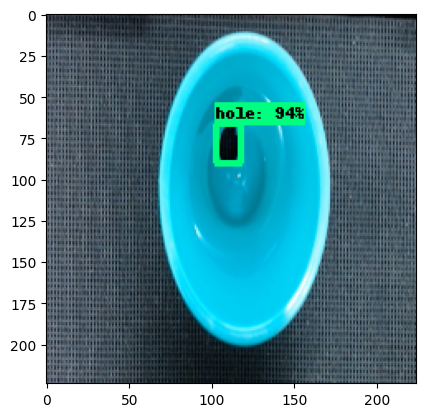

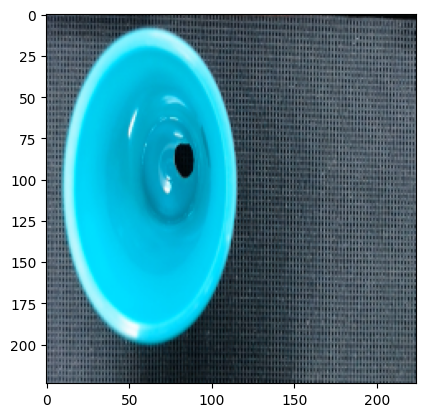

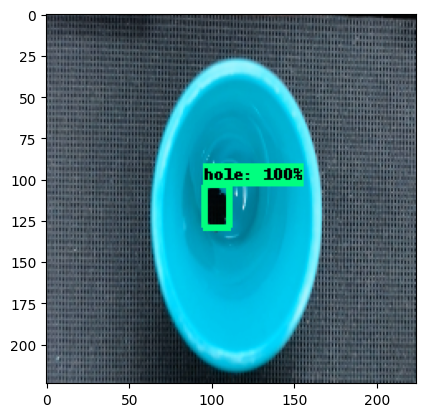

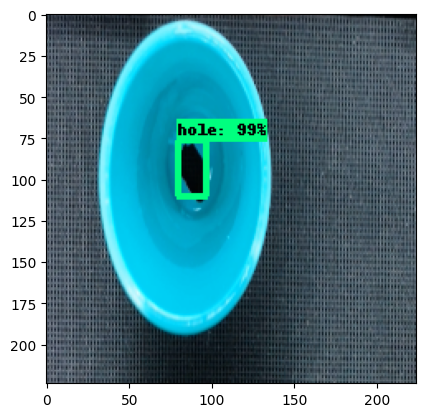

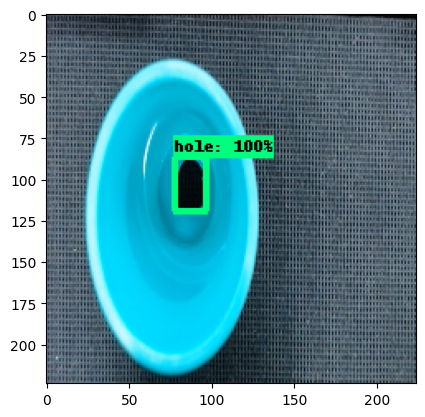

In [42]:
for image_path in IMAGES_PATH:
    img = cv2.imread(image_path)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()